In [1]:
#Import libraries for plotting, sampling
import numpy as np
import matplotlib.pyplot as plt

## Binance Take Home Test - Question 1

*Detection of fake commodity: There are a total of 100,000 pairs of shoes of a well-known brand on an e-commerce platform.
The official guide price of these shoes is $48 ~ $68. Now we randomly sample 1,000 pairs from them for inspection, where 100 pairs of shoes with quality or counterfeit problems are found. The price distribution of the 100 pairs of counterfeit shoes is mainly concentrated on two price points, with 60 pairs for $30 and 40 pairs for $50. Please give the price point at which you can most likely buy qualified shoes at the lowest price. Prerequisite judgments can be made based on personal understanding of real life.*
<br/><br/>

It is given in the problem statement that the price distribution of real and fake shoes differs. By inferring how likely it is that an observed price has been drawn from a particular one of these distributions, it is possible to calculate the probability that the advertised pair of shoes is real. Let the variable $Z$ indicate whether a particular pair of shoes is real or fake: <br/>

$$
Z = 
     \begin{cases}
     1 &\quad\text{Real}\\
     0 &\quad\text{Fake}
     \end{cases}
$$


<br/><br/>
This variable cannot be observed directly - the aim is to therefore to infer the probability that the latent variable $Z=1$, given/conditioned on a the observed price $x$:

$$
p(Z=1|x)
$$

which can be rewritten in terms of the conditional distribution of $x$, and the marginal distribution of $Z$ - distributions that can be estimated from the observations in the problem statement - using Bayes' rule:

$$
\begin{aligned}
p(Z=1|x) &= \frac{p(x|Z=1)p(Z=1)}{p(x)}\\ \\
         &= \frac{p(x|Z=1)p(Z=1)}{\sum_{z\in\{0,1\}}p(x|Z=z)p(Z=z)}
\end{aligned}
$$

<br/>
---

#### **Marginal distribution of Z (real/fake)**

It was observed in the problem statement that, for a sample size of 1000 shoes, 100 shoes were counterfeit or of poor quality. Assuming that the sampling was unbiased, I adopt the following marginal distribution for Z:

$$
p(Z=z) =
     \begin{cases}
     0.9 &\quad z=1\\
     0.1 &\quad z=0
     \end{cases}
$$
---

#### **Conditional price distributions**

I will assume that the conditional price distributions - the price distribution given that a pair of shoes is either real or fake - are Gaussian (or a mixture with Gaussian components). In addition to being common in real life, sampling from a Gaussian distribution is easily facilitated in python. $\mathcal{N}(\mu,\sigma^2)$ denotes a Gaussian/normal distribution with mean $\mu$ and standard deviation $\sigma^2$.

##### **Real shoes**
I will take the guide price of the shoes (\$48 ~ \$68) to correspond to the $\pm 2\sigma$ range, with the mean in the centre (\$58), so that ~95\% of real shoe prices lie in this range. The real distribution cannot feasibly be Gaussian, assuming shoe prices cannot be negative - but this should be a good approximation in the feasible price range, given the mean is ~12 $\sigma$ above the \$0 point.

$$
X|Z=1 \sim \mathcal{N}(58, 5^2)
$$

##### **Fake shoes**
For the price distribution of fake shoes, I assume a Gaussian mixture distribution with component means at the two observed price points of $30 and $50. It is unrealistic to assume all fake shoes are given these prices exactly - otherwise it would be straightforward to avoid fake shoes, by simply buying at any other price point. I will therefore assume an equal standard deviation for each component, with the same value as the standard deviation for real shoe price. The components are weighted according the quantities observed around each price point - 60 pairs at $30 and 40 pairs at $50.

$$
X|Z=0 \sim 0.6\mathcal{N}(30, 5^2) + 0.4\mathcal{N}(50, 5^2)
$$

Both conditional price distributions are plotted below.

In [2]:
#Functions to evaluate normal distribution pdfs
def _standard_normal_pdf(z: float) -> float:
    """
    Evaluates the standard normal distribution at z
    (i.e mean 0, std 1)
    """
    return 1/np.sqrt(2*np.pi) * np.exp(-z**2/2)

def normal_pdf(x: float, mu: float, sigma:float) -> float:
    """
    Evaluates a normal distribution with specified mean and
    standard deviation at x
    """
    if sigma < 0:
        raise ValueError("Standard deviation must be > 0")
    
    return 1/sigma * _standard_normal_pdf((x-mu)/sigma)

In [3]:
#Functions to evaluate conditional pdfs
def real_conditional_pdf(x: float) -> float:
    """
    Evaluates the conditional pdf for real shoes at price x
    """
    return normal_pdf(x, 58, 5)

def fake_conditional_pdf(x:float, sigma:float=5):
    """
    Evaluates conditional pdf for fake shoes at price x, two component gaussians
    """
    return 0.6*normal_pdf(x, 30, sigma) + 0.4*normal_pdf(x, 50, sigma)

Text(0.5, 1.0, 'Conditional distributions for real & fake shoe prices')

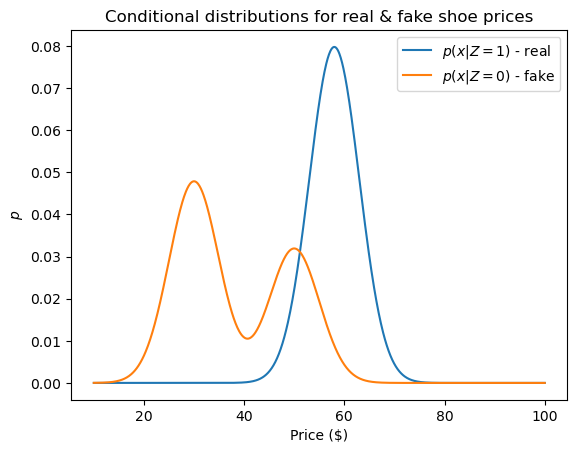

In [4]:
x_samples = np.linspace(10, 100, 1000)

pdf_real = real_conditional_pdf(x_samples)
pdf_fake = fake_conditional_pdf(x_samples)

plt.plot(x_samples, pdf_real)
plt.plot(x_samples, pdf_fake)
plt.xlabel('Price ($)')
plt.ylabel('$p$')
plt.legend(['$p(x|Z=1)$ - real','$p(x|Z=0)$ - fake'])
plt.title('Conditional distributions for real & fake shoe prices')

These conditional distributions can be used in the formulation of Bayes' rule, restated below:

$$
\begin{aligned}
p(Z=1|x) &= \frac{p(x|Z=1)p(Z=1)}{\sum_{z\in\{0,1\}}p(x|Z=z)p(Z=z)}
\end{aligned}
$$

In [5]:
def prob_real(x, sigma_fake=5):
    """
    Returns the probability that a pair of shoes with observed price x is real, using Bayes' rule
    """
    real_conditional = real_conditional_pdf(x)
    fake_conditional = fake_conditional_pdf(x, sigma_fake)
 
    prob_real = 0.9*real_conditional/(0.9*real_conditional + 0.1*fake_conditional) #Marginal distribution of z - z=0 -> 0.1, z=1 -> 0.9, 
    return prob_real

Text(0.5, 1.0, 'Probability of real shoes vs. observed price')

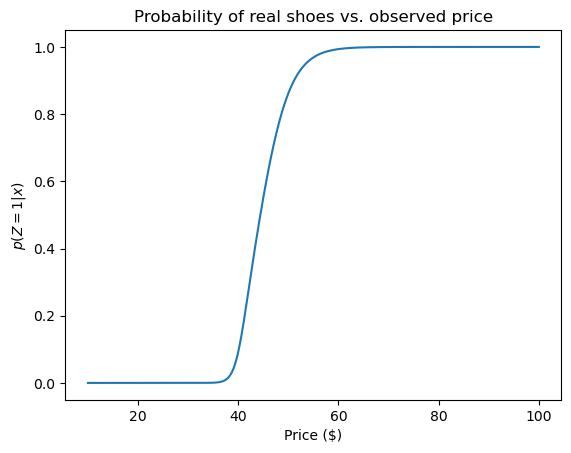

In [6]:
real_probs = prob_real(x_samples)

plt.plot(x_samples, real_probs) #Plot the probability of real shoes
plt.xlabel('Price ($)')
plt.ylabel('$p(Z=1|x)$')
plt.title('Probability of real shoes vs. observed price')

Which results in a curve that, intuitively, seems correct - spending more money increases the chance that the shoes are real. Reading the curve at a given probability:

In [7]:
fifty_threshold = np.interp(0.5, real_probs, x_samples)
ninety_threshold = np.interp(0.9, real_probs, x_samples)
ninetyfive_threshold = np.interp(0.95, real_probs, x_samples)

print(f'Price @50% real probability: {fifty_threshold}')
print(f'Price @90% real probability: {ninety_threshold}')
print(f'Price @95% real probability: {ninetyfive_threshold}')

Price @50% real probability: 44.40546939337773
Price @90% real probability: 51.13746859924322
Price @95% real probability: 53.472024893412055


At a price point of $44, it's more likely than not the shoes are real (under the assumed distributions). 50% is unlikely to be an acceptable level of risk for a consumer though - the 90/95% thresholds are at 51.1/53,5\$ respectively, giving much more favourable odds. I would therefore suggest a **price point of ~53\$** when purchasing the shoes.

---

#### **Changing $\sigma$ for fake shoe price distribution**

Altough a price range is specified for the real shoe distribution, it is less clear how tightly concentrated the fake shoe prices are around the \$30 and \$50 price points. I briefly repeat the analysis above using a smaller (\$7) and larger (\$10) standard deviation. <br/>

##### For $\sigma=\$2$:

Text(0.5, 1.0, 'Probability of real shoes vs. observed price')

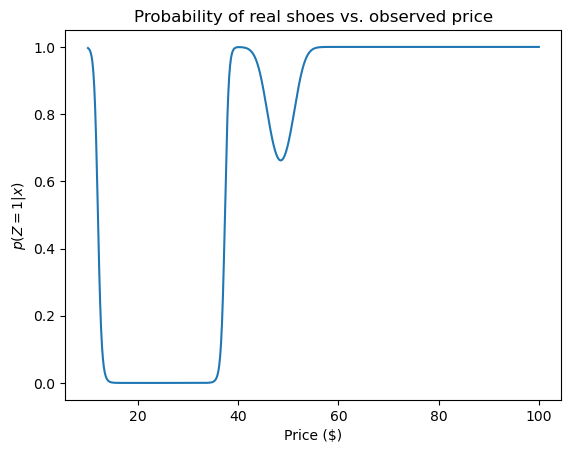

In [8]:
real_probs = prob_real(x_samples, sigma_fake=2)

plt.plot(x_samples, real_probs) #Plot the probability of real shoes
plt.xlabel('Price ($)')
plt.ylabel('$p(Z=1|x)$')
plt.title('Probability of real shoes vs. observed price')

Two strange behaviours are observed:
* At very low prices (\<\$10) the probability of real shoes is unreasonably high - here the assumption of Gaussian price distributions is unlikely to hold - the conditional price distribution for fake shoes would likely have a heavier tail at low prices in reality. Extremely low prices can be discarded a priori as infeasible based on real life experience.
* There is a region within the feasible price range where spending a larger amount decreases the probability of shoes being real ($\sim$\$40-\$45). Although this makes sense mathematically, this seems inconsistent with real life experience so I assume it cannot be the case that $\sigma$ is this low for fake shoes.

---

##### For $\sigma=\$7$:

Text(0.5, 1.0, 'Probability of real shoes vs. observed price')

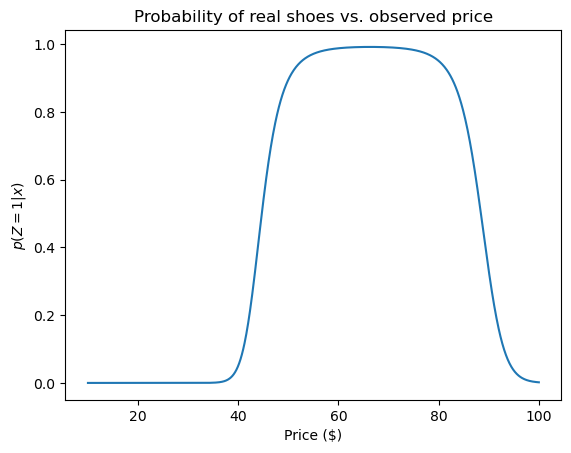

In [9]:
real_probs = prob_real(x_samples, sigma_fake=7)

plt.plot(x_samples, real_probs) #Plot the probability of real shoes
plt.xlabel('Price ($)')
plt.ylabel('$p(Z=1|x)$')
plt.title('Probability of real shoes vs. observed price')

With $\sigma=\$7$, the shape of the curve is roughly the same within the feasible region. Again, the assumption of Gaussian distributions begins to break down far outside the feasible price range - this time, at high prices, where the conditional distribution of fake shoe prices now decays more slowly than for the real price distribution. These extremely high prices can be discarded a priori. Reading the threshold prices within the feasible range (~middle 500 samples):

In [10]:
fifty_threshold = np.interp(0.5, real_probs[250:750], x_samples[250:750])
ninety_threshold = np.interp(0.9, real_probs[250:750], x_samples[250:750])
ninetyfive_threshold = np.interp(0.95, real_probs[250:750], x_samples[250:750])

print(f'Price @50% real probability: {fifty_threshold}')
print(f'Price @90% real probability: {ninety_threshold}')
print(f'Price @95% real probability: {ninetyfive_threshold}')

Price @50% real probability: 44.70055968513277
Price @90% real probability: 50.159413359140316
Price @95% real probability: 52.66428783232409


gives price points that are similar to first analysis. Increasing $\sigma$ further gives a conditional fake price distribution that is not clearly concentrated at \$30/50. The estimate of \$53 seems to hold up reasonably well.

---

##### Empirircal verification
The code below samples from the marginal distribution $p(x)$ using numpy, and calculates $p(z=1|x)$ empirically. It seems to agree with the Bayes' rule analysis.

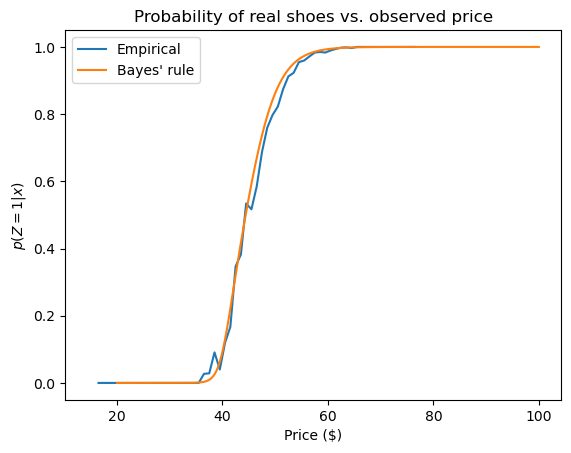

In [87]:
#Verification
num_samples = 20000

z_samples = np.random.binomial(1, 0.9, num_samples) #draw samples from the marginal distribution of z
x_samples = np.zeros(num_samples) #empty array for x samples

for i in range(len(x_samples)): #Draw samples from the MARGINAL distribution of x
    num_real = len(x_samples[z_samples==1]) #Sampled no. of real shoes
    real_samples = np.random.normal(58, 5, num_real) 
    x_samples[z_samples==1] = real_samples #put in array of samples

    #Mixture sampling for fake conditional
    num_fakes = len(x_samples[z_samples==0]) #Sampled no. of fake shoes
    mixture_counts = np.random.binomial(num_fakes, 0.4)  #Number of samples from left component

    fake_samples = np.concatenate([ np.random.normal(30, 5, mixture_counts), np.random.normal(50, 5, num_fakes-mixture_counts)]) #n=mixture_counts samplesfrom left component, n=total_fakes-mixture_counts from right component.
    x_samples[z_samples==0] = fake_samples

#Calculate p(z=1|x) using 1 dollar price buckets
bucket_centres = []
prob_real_empirical = []
for lower in range(10,100): #Lower end of buckets
    bucket_centres.append(lower+0.5)
    z_bucket = z_samples[(lower <= x_samples) & (x_samples < lower+1)] #z samples w/ price in bucket

    if len(z_bucket) > 0:
        prob_real_empirical.append( #Probability of real shoes is fraction of real shoes in this bucket
            len(z_bucket[z_bucket==1])/len(z_bucket)
        )
    else:
        prob_real_empirical.append(None)

plt.plot(bucket_centres, prob_real_empirical)

x_axis = np.linspace(20,100,10000)
plt.plot(x_axis, prob_real(x_axis))

plt.xlabel('Price ($)')
plt.ylabel('$p(Z=1|x)$')
plt.title('Probability of real shoes vs. observed price')
plt.legend(['Empirical', 'Bayes\' rule'])